In [6]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np

if not tf.__version__.startswith('2'):
    raise ValueError('This code requires TensorFlow V2.x')


In [7]:
(train_data, test_data), info = tfds.load('imdb_reviews',split=[tfds.Split.TRAIN, tfds.Split.TEST],as_supervised=True,with_info=True)

C:\Users\devdn\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:   0%|          | 0/1 [09:55<?, ? url/s]


KeyboardInterrupt: 

In [3]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir=PosixGPath('/tmp/tmptvf2aeqntfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInfo

In [4]:
print(len(train_data))
print(len(test_data))

25000
25000


In [5]:
for review, label in train_data.take(2):  
    print("Review:", review.numpy().decode('utf-8'))  
    print("Sentiment:", "Positive" if label.numpy() == 1 else "Negative")

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Sentiment: Negative
Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was ru

In [6]:
# Tokenize and pad the reviews
tokenizer = keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')
train_sentences, train_labels = zip(*[(sent.numpy().decode('utf8'), label.numpy()) for sent, label in train_data])
tokenizer.fit_on_texts(train_sentences)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=100, padding='post', truncating='post')

test_sentences, test_labels = zip(*[(sent.numpy().decode('utf8'), label.numpy()) for sent, label in test_data])
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=100, padding='post', truncating='post')

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)


In [7]:
model = keras.models.Sequential([
            keras.layers.Embedding(10000, 64),
            keras.layers.SimpleRNN(64),
            keras.layers.Dense(1, activation='sigmoid')
        ])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train_padded, train_labels, epochs=1, validation_data=(test_padded, test_labels))

782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.5131 - loss: 0.6952 - val_accuracy: 0.5302 - val_loss: 0.6890


In [8]:
print("Training Loss per epoch:", history.history['loss'])
print("Training Accuracy per epoch:", history.history['accuracy'])
print("Validation Loss per epoch:", history.history['val_loss'])
print("Validation Accuracy per epoch:", history.history['val_accuracy'])

Training Loss per epoch: [0.6938395500183105]
Training Accuracy per epoch: [0.5180400013923645]
Validation Loss per epoch: [0.6890280246734619]
Validation Accuracy per epoch: [0.5302000045776367]


In [9]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5307 - loss: 0.6888
Test Accuracy: 0.5302
Test Loss: 0.6890


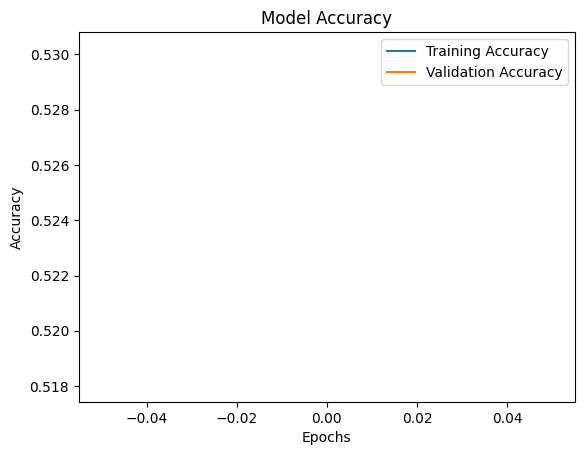

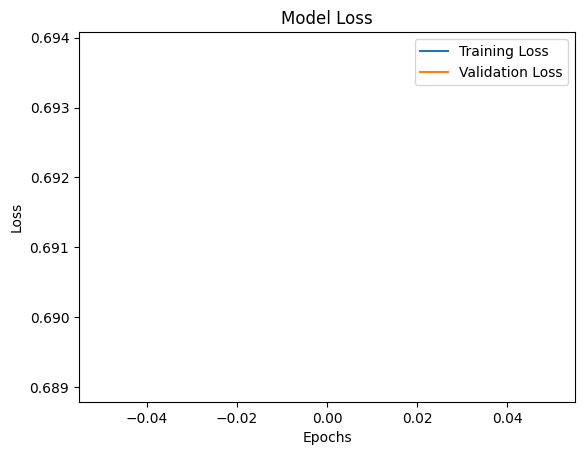

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [11]:
sample_texts = ["This is a great product!", "I had a terrible experience."]
sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_padded = keras.preprocessing.sequence.pad_sequences(sample_sequences, maxlen=100, padding='post', truncating='post')

predictions = model.predict(sample_padded)
predicted_labels = ['Positive' if p > 0.5 else 'Negative' for p in predictions]

for text, label in zip(sample_texts, predicted_labels):
    print(f"Review: {text} | Sentiment: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Review: This is a great product! | Sentiment: Positive
Review: I had a terrible experience. | Sentiment: Positive


In [12]:
model = keras.models.Sequential([
            keras.layers.Embedding(10000, 32), # Reduced embedding dimension
            keras.layers.Dropout(0.5), # Added dropout
            keras.layers.SimpleRNN(32, kernel_regularizer=keras.regularizers.l2(0.001)), # L2 regularization
            keras.layers.Dense(1, activation='sigmoid')
        ])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Adding early stopping callback
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_padded, train_labels, epochs=1, validation_data=(test_padded, test_labels), callbacks=[early_stop])


782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.5048 - loss: 0.7203 - val_accuracy: 0.5234 - val_loss: 0.7006


In [13]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5264 - loss: 0.7004
Test Accuracy: 0.5234
Test Loss: 0.7006


In [14]:
sample_texts = ["This is a great product!", "I had a terrible experience."]
sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_padded = keras.preprocessing.sequence.pad_sequences(sample_sequences, maxlen=100, padding='post', truncating='post')

predictions = model.predict(sample_padded)
predicted_labels = ['Positive' if p > 0.5 else 'Negative' for p in predictions]

for text, label in zip(sample_texts, predicted_labels):
    print(f"Review: {text} | Sentiment: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Review: This is a great product! | Sentiment: Positive
Review: I had a terrible experience. | Sentiment: Positive


In [15]:
from keras.layers import Bidirectional, LSTM

model = keras.models.Sequential([
            keras.layers.Embedding(10000, 32),
            Bidirectional(LSTM(32, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=keras.regularizers.l2(0.001))),
            keras.layers.Dense(1, activation='sigmoid')
        ])

model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_padded, train_labels, epochs=1, validation_data=(test_padded, test_labels), callbacks=[early_stop])


782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 74ms/step - accuracy: 0.5913 - loss: 0.6833 - val_accuracy: 0.7724 - val_loss: 0.5044


In [16]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7724 - loss: 0.5056
Test Accuracy: 0.7724
Test Loss: 0.5044


In [17]:
sample_texts = ["This is a great product!", "I had a terrible experience."]
sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_padded = keras.preprocessing.sequence.pad_sequences(sample_sequences, maxlen=100, padding='post', truncating='post')

predictions = model.predict(sample_padded)
predicted_labels = ['Positive' if p > 0.5 else 'Negative' for p in predictions]

for text, label in zip(sample_texts, predicted_labels):
    print(f"Review: {text} | Sentiment: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
Review: This is a great product! | Sentiment: Positive
Review: I had a terrible experience. | Sentiment: Negative


In [18]:
from keras.layers import Conv1D, MaxPooling1D

model = keras.models.Sequential([
            keras.layers.Embedding(10000, 32),
            Conv1D(32, 7, activation='relu'),
            MaxPooling1D(5),
            Bidirectional(LSTM(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=keras.regularizers.l2(0.001))),
            Bidirectional(LSTM(32, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=keras.regularizers.l2(0.001))),
            keras.layers.Dense(1, activation='sigmoid')
        ])

model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.RMSprop(learning_rate=0.001), metrics=["accuracy"])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint = keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)

history = model.fit(train_padded, train_labels, epochs=1, validation_data=(test_padded, test_labels), callbacks=[early_stop, checkpoint])


782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.5646 - loss: 0.7552 - val_accuracy: 0.8028 - val_loss: 0.4330


In [19]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8052 - loss: 0.4326
Test Accuracy: 0.8028
Test Loss: 0.4330


In [20]:
sample_texts = ["This is a great product!", "I had a terrible experience."]
sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_padded = keras.preprocessing.sequence.pad_sequences(sample_sequences, maxlen=100, padding='post', truncating='post')

predictions = model.predict(sample_padded)
predicted_labels = ['Positive' if p > 0.5 else 'Negative' for p in predictions]

for text, label in zip(sample_texts, predicted_labels):
    print(f"Review: {text} | Sentiment: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
Review: This is a great product! | Sentiment: Positive
Review: I had a terrible experience. | Sentiment: Negative
